# NCAA Track and Field Championships

In [2]:
from ncaa_analysis import *

### Download Data and Add Metrics

In [4]:
dfs_f_o, dfs_m_o = download_flashresults(season='Outdoor', export=True)
dfs_f_i, dfs_m_i = download_flashresults(season='Indoor', export=True)

## EDA

### Women's Outdoor Championships

In [ ]:
dfs_f_o = add_metrics(dfs_f_o)

#### t-SNE

In [71]:
from sklearn.manifold import TSNE

women_outdoor_tsne = TSNE(n_components=2, 
                          learning_rate='auto',
                          perplexity=45,
                          init='pca', 
                          random_state=69420).fit_transform(dfs_f_o.select_dtypes(['float', 'int']))

dfs_f_o[['tsne_x', 'tsne_y']] = women_outdoor_tsne

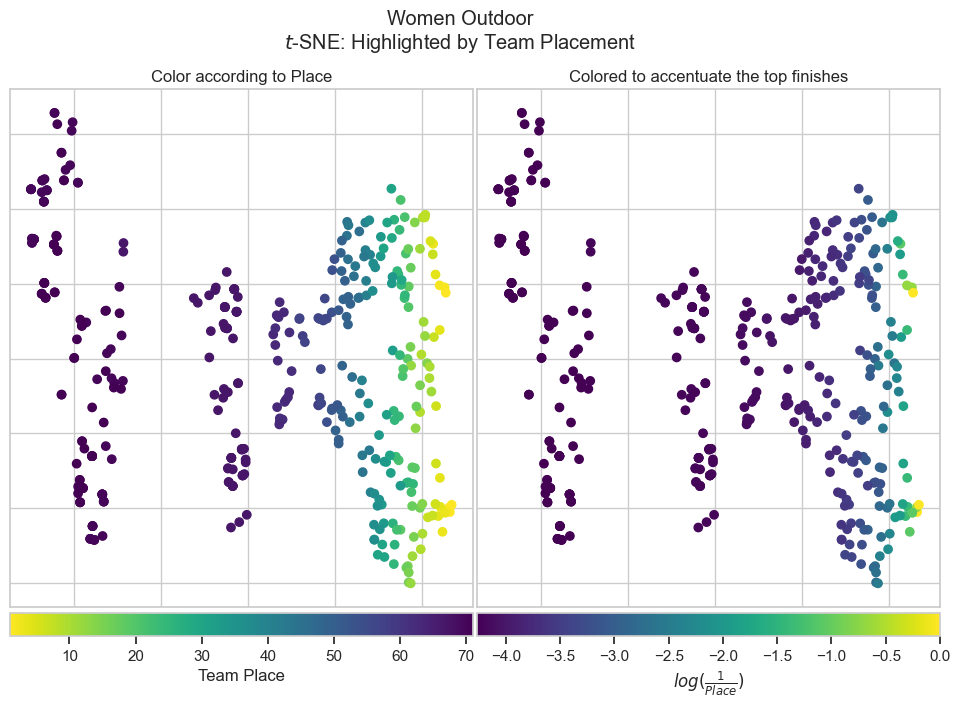

In [72]:
plt.figure(figsize=(12,8))
plt.suptitle('Women Outdoor\n$t$-SNE: Highlighted by Team Placement')

plot1_cmap = cmp['viridis'].reversed()
plt.subplot(1,2,1)
plt.scatter(x=dfs_f_o['tsne_x'], 
            y=dfs_f_o['tsne_y'], 
            c=dfs_f_o['place'], 
            cmap=plot1_cmap)
plt.colorbar(orientation='horizontal', 
             pad=0.01,
             label='Team Place')
plt.title('Color according to Place')
plt.tick_params(left=None, labelleft=False,
                bottom=None, labelbottom=False)

plt.subplot(1,2,2)
plt.scatter(x=dfs_f_o['tsne_x'], 
            y=dfs_f_o['tsne_y'], 
            c=np.log(1 / dfs_f_o['place']), 
            cmap='viridis')
plt.colorbar(orientation='horizontal', 
             pad=0.01,
             label=r'$log(\frac{1}{Place})$')
plt.title('Colored to accentuate the top finishes')
plt.tick_params(left=None, labelleft=False,
                bottom=None, labelbottom=False)

plt.subplots_adjust(wspace=0.01)

plt.show()

Scoring in the Top 10 seems to be possible in a variety of ways, but there are two distinct hubs for the top ~3.

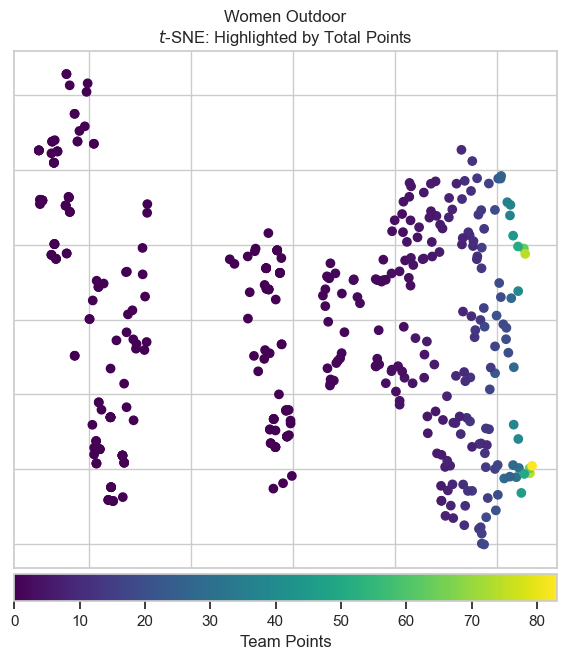

In [73]:
plt.figure(figsize=(7,8))
plt.scatter(x=dfs_f_o['tsne_x'], 
            y=dfs_f_o['tsne_y'], 
            c=dfs_f_o['total_points'], 
            cmap='viridis')
plt.colorbar(orientation='horizontal', 
             pad=0.01,
             label='Team Points')
plt.title('Women Outdoor\n$t$-SNE: Highlighted by Total Points')
plt.tick_params(left=None, labelleft=False,
                bottom=None, labelbottom=False)
plt.show()

Again, we see there are clearly two distinct clusters that allow you to maximize points that will score you team podium finishes.

##### Theory 1: Specializing in Track or Field Points

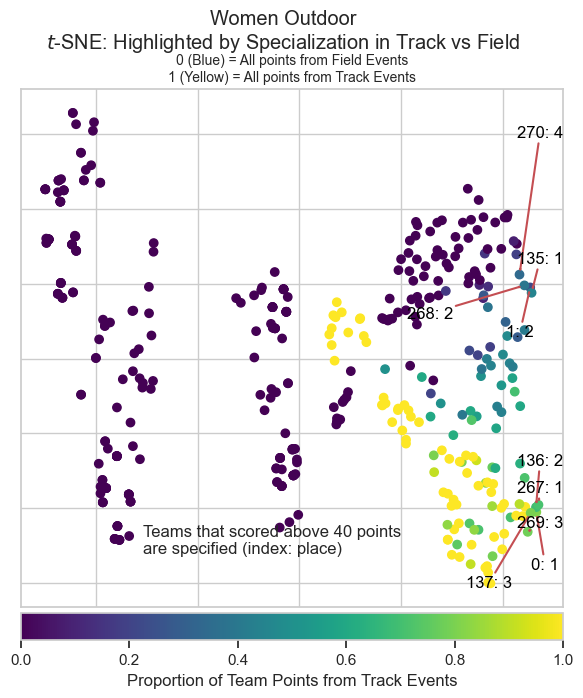

In [74]:
plt.figure(figsize=(7,8))
plt.scatter(x=dfs_f_o['tsne_x'], 
            y=dfs_f_o['tsne_y'], 
            c=dfs_f_o['track_vs_field_track_proportion'], 
            # s=1/dfs_f_o['place'] * 500,
            cmap='viridis')
plt.colorbar(orientation='horizontal', 
             pad=0.01,
             label='Proportion of Team Points from Track Events')
plt.suptitle('Women Outdoor\n$t$-SNE: Highlighted by Specialization in Track vs Field', 
              y=0.98)
plt.title('0 (Blue) = All points from Field Events\n1 (Yellow) = All points from Track Events',
          fontsize='small')
plt.tick_params(left=None, labelleft=False,
                bottom=None, labelbottom=False)

text_labels = []
for idx, row in dfs_f_o.iterrows():
    if row['total_points'] >= 40:
        text_labels.append(plt.text(row['tsne_x'], row['tsne_y'], f'''{idx}: {row['place']}''',
                                    c='black'))
adjust_text(text_labels, 
            only_move={'points':'y', 'texts':'xy'},
            arrowprops=dict(arrowstyle="->", color='r', lw=1.5),
            force_text=(4,5))

plt.figtext(0.3, 0.3, s='Teams that scored above 40 points\nare specified (index: place)')

plt.show()

Clearly a strong degree of specialization, but both clusters of highest team points/placement involve points from both the track and the field.

In [75]:
dfs_f_o.sort_values(by=['place', 'total_points'], 
                    axis=0,
                    ascending=[True, False])[['place', 'team_w', 'total_points', 'track_vs_field_track_proportion']] \
        .head(9) \
        .style.format(precision=2)

,place,team_w,total_points,track_vs_field_track_proportion
267,1,Texas,83.00,0.71
0,1,USC,74.00,0.81
135,1,Florida,74.00,0.45
136,2,Texas,64.00,0.69
1,2,Texas A&M,63.00,0.22
268,2,Florida,51.00,0.39
137,3,Kentucky,50.00,0.80
269,3,Arkansas,46.00,0.78
2,3,Georgia,37.50,0.00


#### Team Points over Time

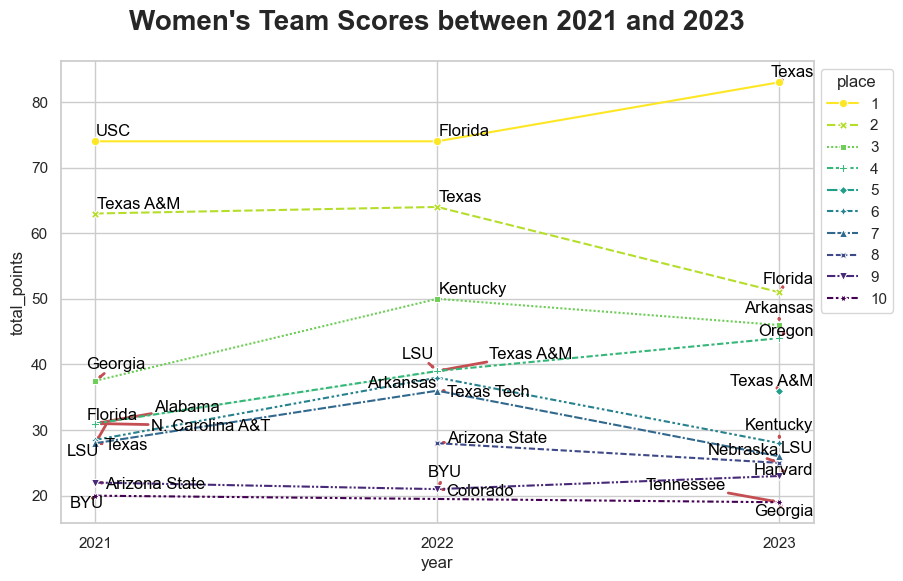

In [76]:
ts_f_o = dfs_f_o.loc[dfs_f_o['place'] <= 10].reset_index(drop=True)

color_vals = cmp['viridis'].reversed()(np.linspace(0, 1, num=10))

plt.figure(figsize=(6*1.618, 6))
ts_plot = sns.lineplot(x='year', 
                       y='total_points', 
                       hue='place', 
                       style='place',
                       markers=True,
                       data=ts_f_o, 
                       palette=list(color_vals))
ts_plot.set_xticks(range(2021,2024,1))
ts_plot.set_title('''Women's Team Scores between 2021 and 2023''', 
                  fontsize=20, 
                  y=1.05,
                  weight='bold')
sns.move_legend(obj=ts_plot, loc='upper left', bbox_to_anchor=(1, 1))

ts_labels=[]
for idx, row in ts_f_o.iterrows():
    ts_labels.append(plt.text(row['year'], row['total_points'], f'''{row['team_w']}''',
                                c='black'))
adjust_text(ts_labels, 
            only_move={'points':'xy', 'texts':'xy'},
            arrowprops=dict(arrowstyle="->", color='r', lw=2),
            force_text=(1,1))

plt.show()

#### Correlations

- Points vs std points is linear, but obviously increasing variance
- Points vs n disciplines is linear
- Place vs std points is curvilinear
- Place vs n disciplines is curvilinear

##### Events

In [77]:
n_cols = ['total_points', 'place'] + \
         [col for col in dfs_f_o.columns if 'n_e' in col] + \
         ['n_disciplines_10_pts_or_more', 'mean_n_disciplines']
dfs_f_o[n_cols].corr(method='spearman')[['total_points', 'place']].iloc[2:]\
               .style.set_caption('Spearman Correlation Coefficients') \
               .set_table_styles([
                        {
                            'selector': 'caption',
                            'props': [
                                ('font-family', 'Franklin Gothic Book'),
                                ('font-weight', 'bold'),
                                ('font-size', '20px'),
                                ('margin', '0 0 10px 0')
                                ]
                        }
               ]) \
               .format(precision=2)

,total_points,place
n_events_participated,0.72,-0.68
n_events_10_pts_or_more,0.58,-0.54
n_events_8_pts_or_more,0.73,-0.69
n_events_6_pts_or_more,0.82,-0.77
n_events_5_pts_or_more,0.88,-0.83
n_events_4_pts_or_more,0.90,-0.85
n_events_3_pts_or_more,0.94,-0.89
n_events_2_pts_or_more,0.96,-0.91
n_events_1_pts_or_more,0.98,-0.92
n_events_sprints,0.43,-0.41


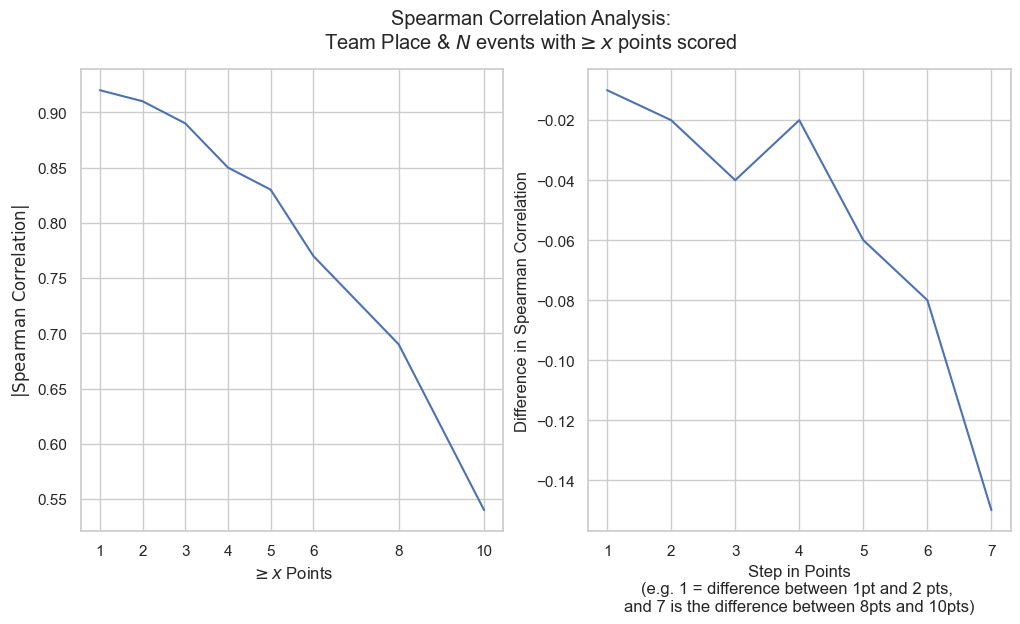

In [78]:
plt.figure(figsize=(12,6))
plt.suptitle('Spearman Correlation Analysis:\nTeam Place & $N$ events with$\geq x$ points scored')

plt.subplot(1,2,1)
plt.plot(list(reversed([1,2,3,4,5,6,8,10])),
         np.abs([-0.54,-0.69,-0.77,-0.83,-0.85,-0.89,-0.91,-0.92,]))
plt.xlabel('$\geq x$ Points')
plt.xticks([1,2,3,4,5,6,8,10])
plt.ylabel(r'$|\text{Spearman Correlation}|$')

plt.subplot(1,2,2)
plt.plot(range(7,0,-1),  
        np.diff(([-0.54,-0.69,-0.77,-0.83,-0.85,-0.89,-0.91,-0.92,])))
plt.xlabel('Step in Points\n(e.g. 1 = difference between 1pt and 2 pts, \nand 7 is the difference between 8pts and 10pts)')
plt.xticks([1,2,3,4,5,6,7])
plt.ylabel('Difference in Spearman Correlation')

plt.show()

C:\Users\mitch\AppData\Local\Temp\ipykernel_512\1044114933.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfs_f_o['log_1_place'] = np.log(1 / dfs_f_o['place'])


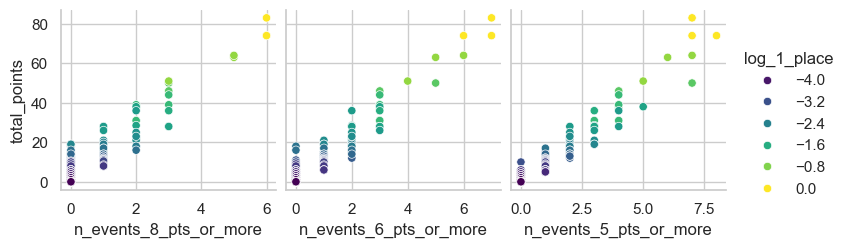

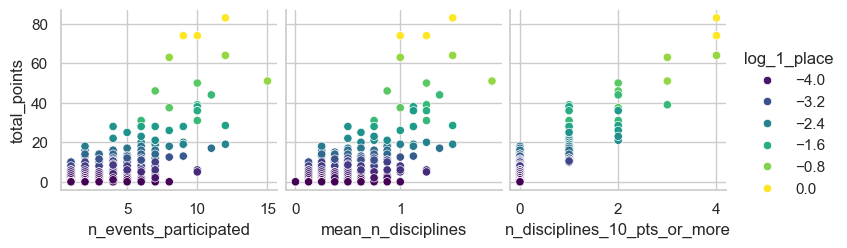

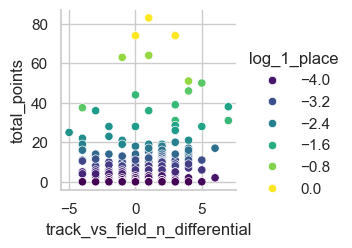

In [79]:
dfs_f_o['log_1_place'] = np.log(1 / dfs_f_o['place'])

n_events_cols = [
    'total_points',
    'log_1_place',
    'n_events_participated',
    'n_events_8_pts_or_more',
    'n_events_6_pts_or_more',
    'n_events_5_pts_or_more',
    'mean_n_disciplines',
    'n_disciplines_10_pts_or_more',
]

sns.pairplot(dfs_f_o[n_events_cols], 
             hue='log_1_place', 
             palette='viridis',
             y_vars='total_points',
             x_vars=['n_events_8_pts_or_more',
                     'n_events_6_pts_or_more',
                     'n_events_5_pts_or_more'])
plt.show()

sns.pairplot(dfs_f_o[n_events_cols], 
             hue='log_1_place', 
             palette='viridis', 
             y_vars='total_points',
             x_vars=['n_events_participated',
                     'mean_n_disciplines',
                     'n_disciplines_10_pts_or_more'])
plt.show()

sns.pairplot(dfs_f_o[['total_points', 'log_1_place', 
                     'track_vs_field_n_differential', 'track_vs_field_track_proportion', 
                     'track_vs_field_differential']],
             hue='log_1_place',
             y_vars='total_points',
             x_vars=['track_vs_field_n_differential'],
             palette='viridis')
plt.show()

Obviously, you want to participate in every event you can, and you want to score in every event you participate in. Additionally, you want to be scoring a minimum of 5-6 points in your events to have the best chances for winning. There are more track events than field events, so it makes sense that there's a higher correlation of track over field events. Relays have a relatively high impact, even though there's only three per championship event. 

There are more track events than field events.

Need to participate in around 7 events to be in the top 3.

Is there a higher number of participants in distance events per number of scorers? They have a pretty low correlation value.

You want to score 10+ points in about 4 disciplines to have the best shot at winning.

##### Points

Higher standard deviations can indicate specialization/maxing out points in certain events while getting only a couple points in others. Where this fails as a metric is when you completely dominate a given discipline. For example, if you score 8+ points in each distance event, you'll have a smaller standard deviation.

In [80]:
std_cols = ['total_points', 'place'] + [col for col in dfs_f_o.columns if 'std' in col] + ['mean_pts_disciplines']
std_corrs = dfs_f_o[std_cols].corr(method='spearman')[['total_points', 'place']].iloc[2:]

std_cols_long = pd.melt(
    frame=dfs_f_o[std_cols],
    id_vars=['total_points', 'place']
)

std_corrs.style.set_caption('Spearkman Correlation Coefficients') \
               .set_table_styles([
                        {
                            'selector': 'caption',
                            'props': [
                                ('font-family', 'Franklin Gothic Book'),
                                ('font-weight', 'bold'),
                                ('font-size', '20px'),
                                ('margin', '0 0 10px 0')
                                ]
                        }
               ]) \
               .format(precision=2)

,total_points,place
std_pts_per_event,0.90,-0.85
std_pts_sprints,0.43,-0.41
std_pts_hurdles,0.24,-0.23
std_pts_mid_distance,0.31,-0.29
std_pts_distance,0.32,-0.29
std_pts_jumps,0.39,-0.37
std_pts_throws,0.33,-0.31
std_pts_track,0.70,-0.66
std_pts_field,0.62,-0.58
std_pts_disciplines,0.99,-0.94


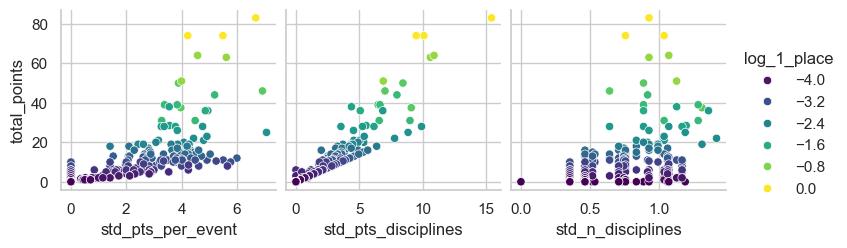

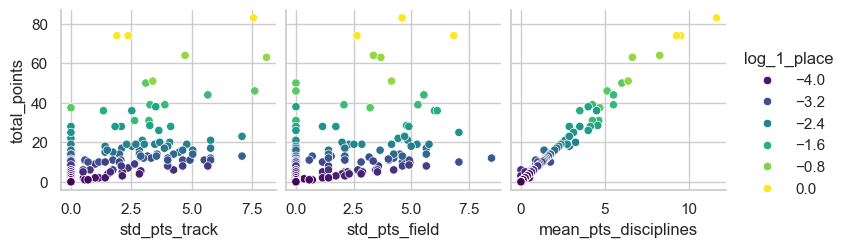

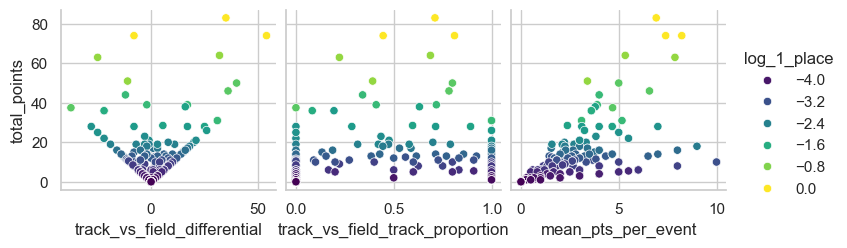

In [81]:
# dfs_f_o['log_1_place'] = np.log(1 / dfs_f_o['place'])

std_pts_cols = [
    'total_points',
    'log_1_place',
    'std_pts_per_event',
    'std_pts_disciplines',
    'std_n_disciplines',
    'std_pts_track',
    'std_pts_field',  
    'mean_pts_disciplines', 
]


sns.pairplot(dfs_f_o[std_pts_cols],
             y_vars='total_points', 
             x_vars=['std_pts_per_event',
                     'std_pts_disciplines',
                     'std_n_disciplines'],
             hue='log_1_place', 
             palette='viridis')
plt.show()

sns.pairplot(dfs_f_o[std_pts_cols],
             y_vars='total_points', 
             x_vars=['std_pts_track',
                     'std_pts_field',  
                     'mean_pts_disciplines',],
             hue='log_1_place', 
             palette='viridis')
plt.show()

sns.pairplot(dfs_f_o[['total_points', 'log_1_place', 
                     'track_vs_field_n_differential', 'track_vs_field_track_proportion', 
                     'track_vs_field_differential', 'n_events_participated', 'mean_pts_per_event']],
             hue='log_1_place',
             y_vars='total_points',
             x_vars=['track_vs_field_differential', 'track_vs_field_track_proportion', 'mean_pts_per_event'],
             palette='viridis')
plt.show()

Specialization among disciplines is more important than specialization within a discipline.

Need to score an average of 5 pts per discipline participated in to score in the top 3.

If you're going to depend on field events, you really need to be dominant.

### Men's Outdoor Championships

In [11]:
dfs_m_o = add_metrics(dfs_m_o)
dfs_m_o.head()

,place,team,total_points,100,200,400,800,1500,3000SC,5000,...,mean_n_disciplines,median_n_disciplines,std_n_disciplines,n_disciplines_10_pts_or_more,track_vs_field_differential,track_vs_field_mean_differential,track_vs_field_n_differential,track_vs_field_track_proportion,track_vs_field_field_proportion,log_1_place
0,1,LSU,84.0,10.0,8.0,6.0,0.0,0.0,0.0,0.0,...,1.500,1.5,1.195229,5,6.0,-0.300000,1,0.535714,0.464286,0.000000
1,2,Oregon,53.0,6.0,0.0,0.0,6.0,10.0,0.0,15.0,...,1.375,1.0,0.517549,3,25.0,0.904762,4,0.735849,0.264151,-0.693147
2,3,N. Carolina A&T,35.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,...,1.125,1.0,1.125992,1,15.0,-2.142857,6,0.571429,0.428571,-1.098612
3,4,Florida,34.5,2.0,10.0,3.0,0.0,0.0,0.0,0.0,...,1.000,1.0,0.925820,2,-2.5,-0.625000,0,0.434783,0.565217,-1.386294
4,5,USC,33.0,4.0,3.0,0.0,10.0,0.0,0.0,0.0,...,1.500,2.0,1.069045,1,24.0,3.214286,3,0.787879,0.212121,-1.609438


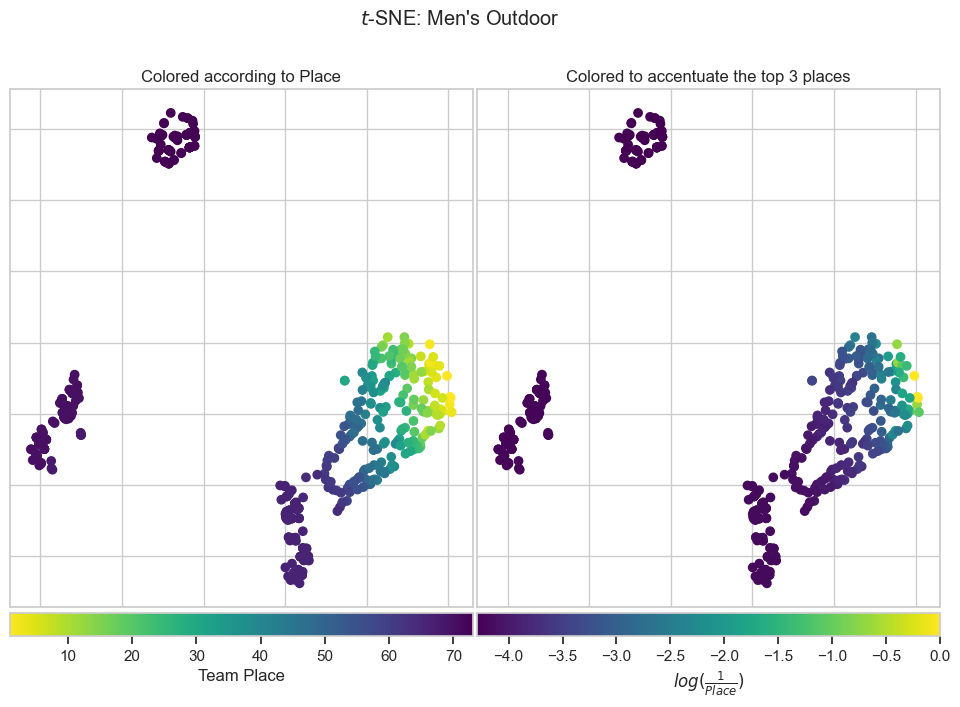

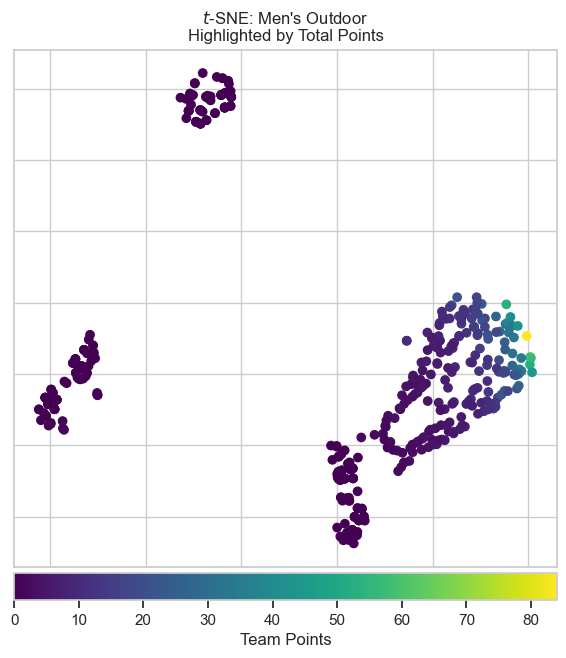

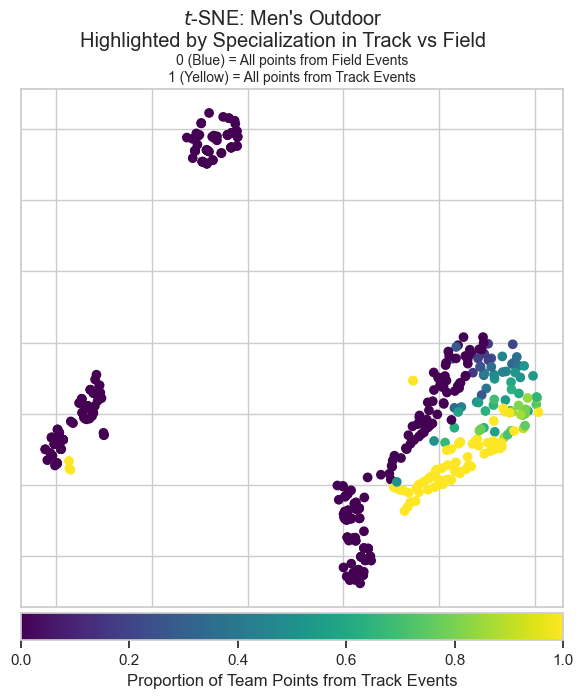

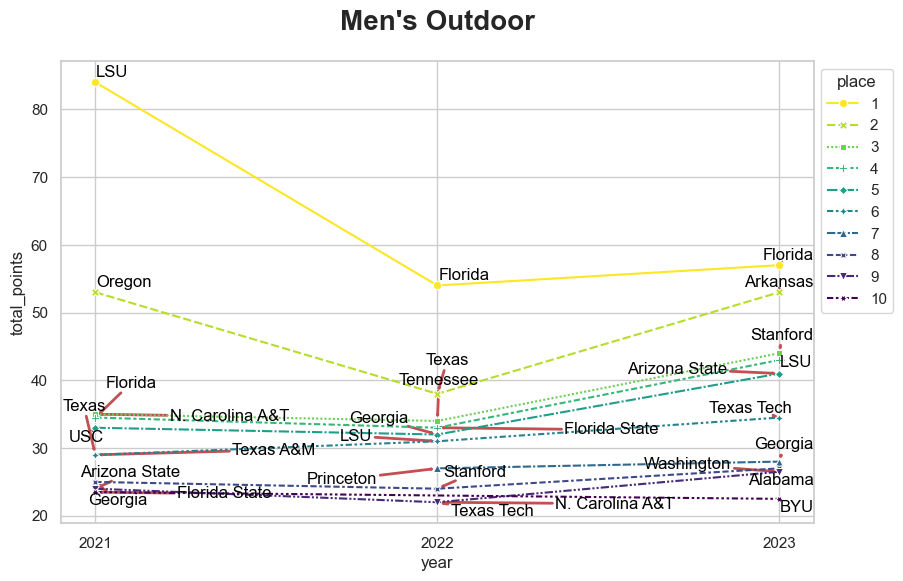

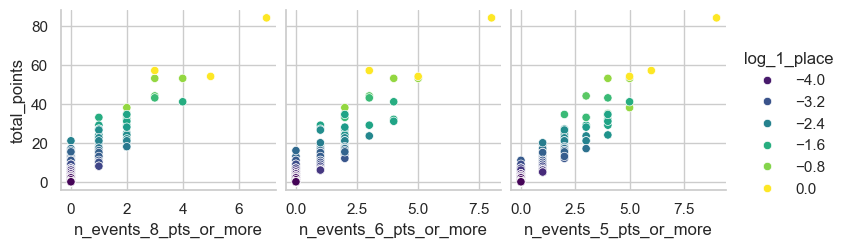

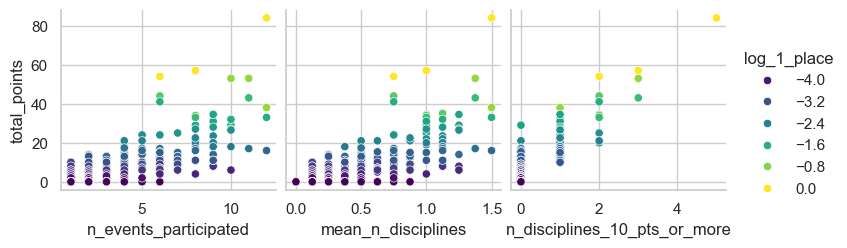

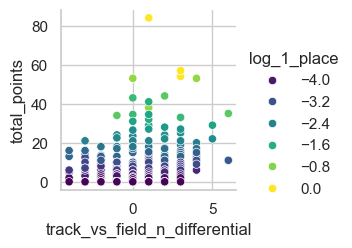

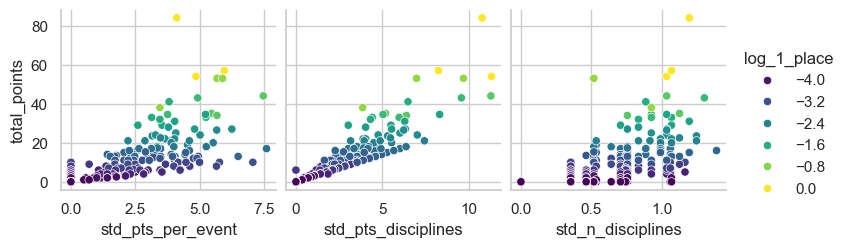

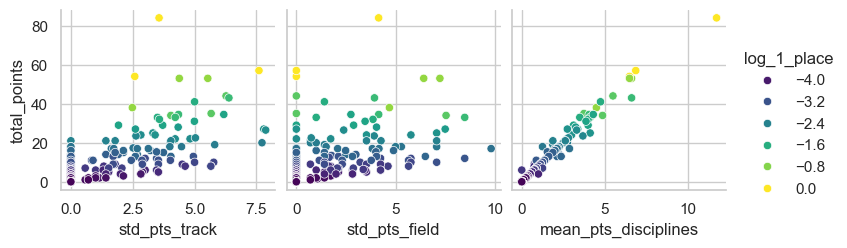

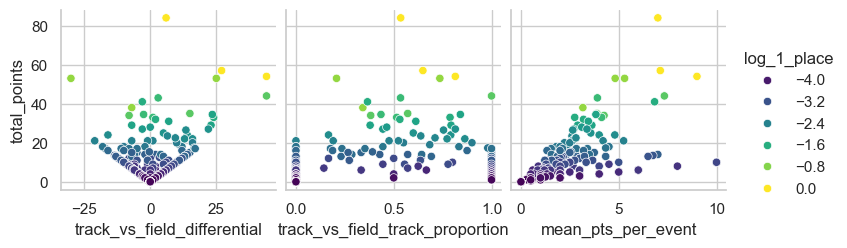

In [13]:
events_table, points_table = perform_basic_analysis(dfs_m_o, title="Men's Outdoor")

In [15]:
events_table

,total_points,place
n_events_participated,0.72,-0.68
n_events_10_pts_or_more,0.58,-0.54
n_events_8_pts_or_more,0.72,-0.67
n_events_6_pts_or_more,0.82,-0.77
n_events_5_pts_or_more,0.86,-0.81
n_events_4_pts_or_more,0.91,-0.86
n_events_3_pts_or_more,0.95,-0.89
n_events_2_pts_or_more,0.97,-0.91
n_events_1_pts_or_more,0.97,-0.91
n_events_sprints,0.45,-0.43


In [16]:
points_table

,total_points,place
std_pts_per_event,0.90,-0.84
std_pts_sprints,0.47,-0.45
std_pts_hurdles,0.24,-0.23
std_pts_mid_distance,0.32,-0.30
std_pts_distance,0.29,-0.28
std_pts_jumps,0.38,-0.35
std_pts_throws,0.39,-0.37
std_pts_track,0.70,-0.66
std_pts_field,0.67,-0.63
std_pts_disciplines,0.99,-0.92


### Women's Indoor Championships

In [17]:
dfs_f_i = add_metrics(dfs_f_i)

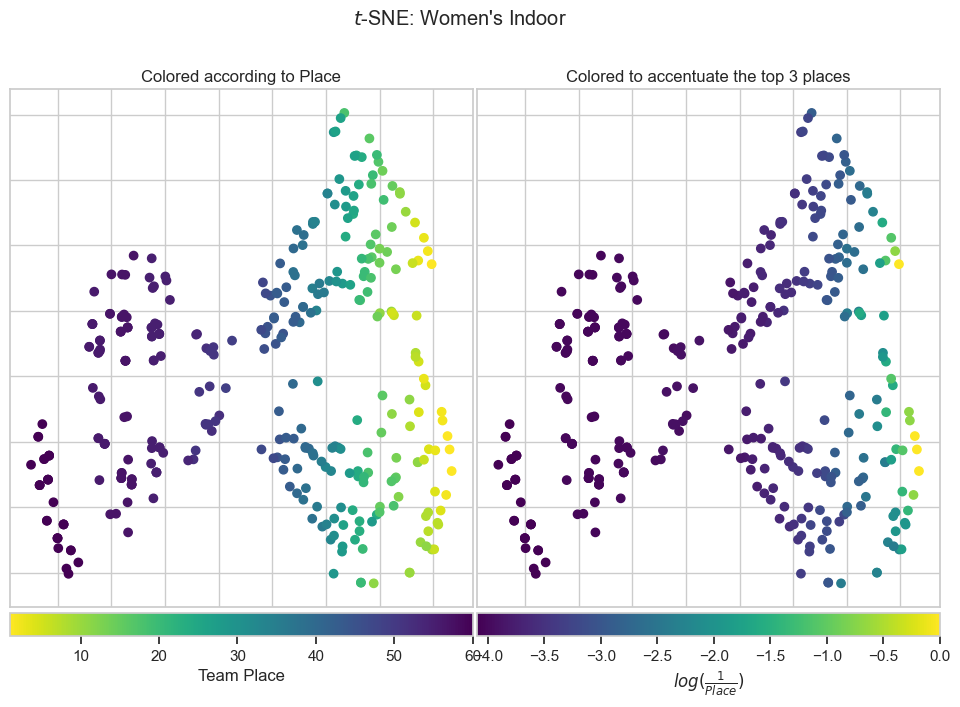

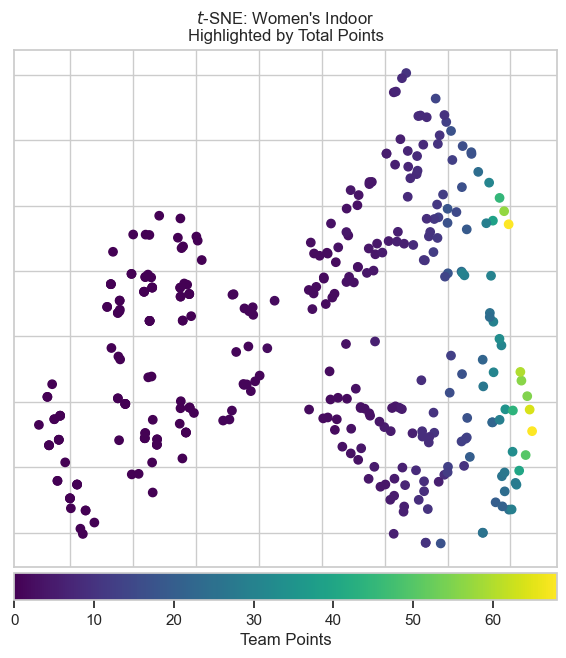

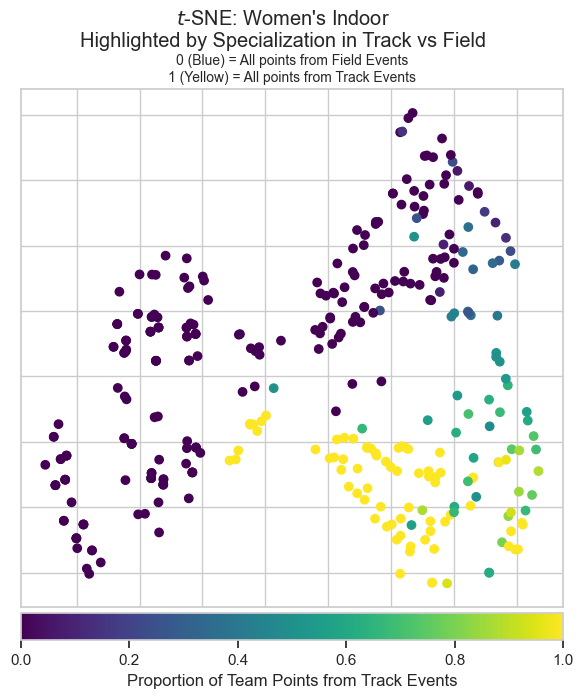

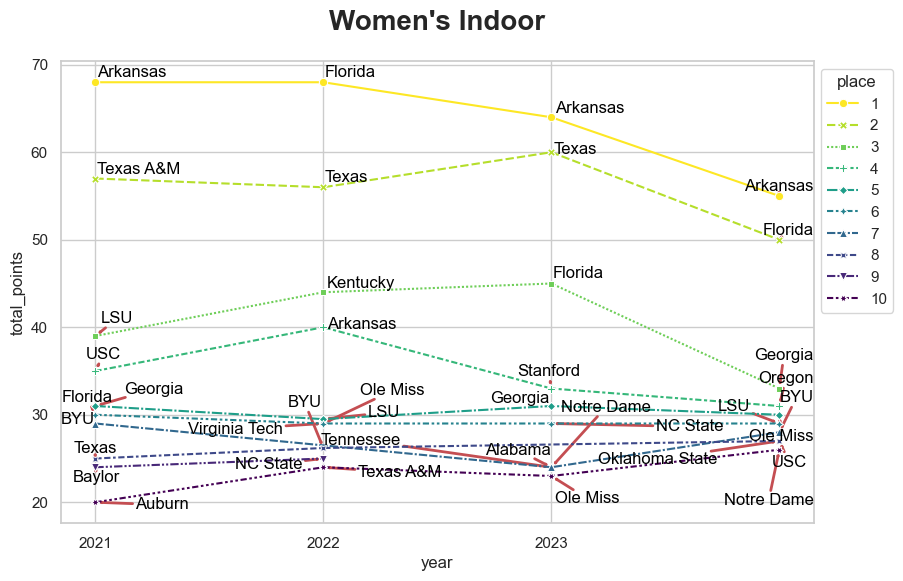

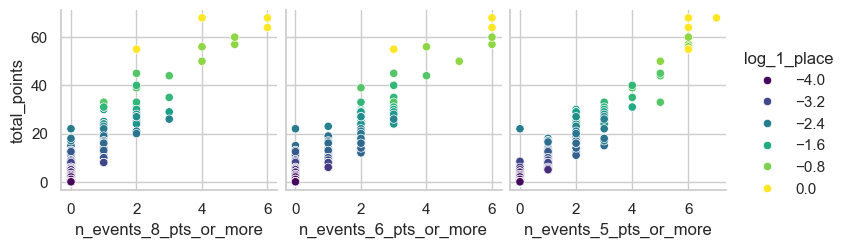

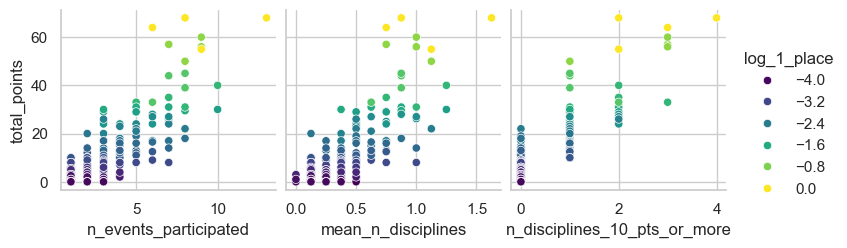

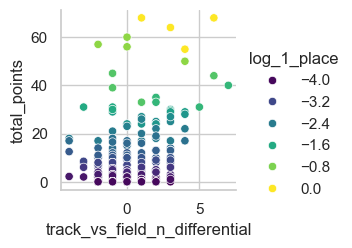

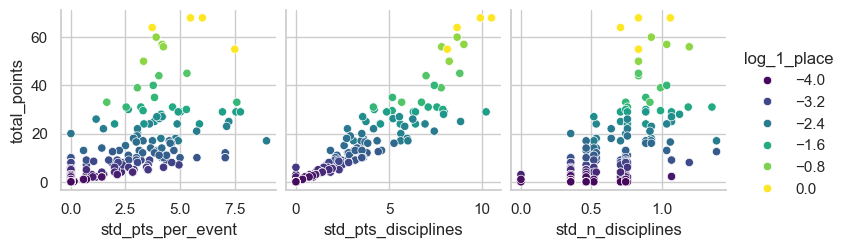

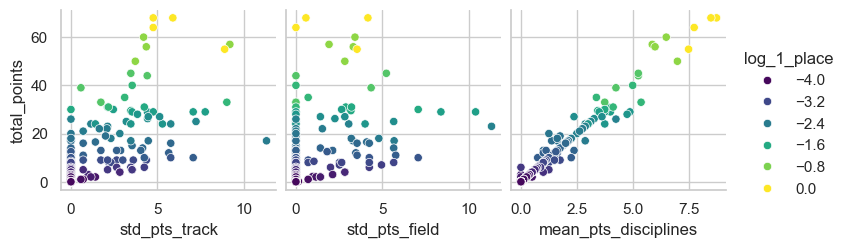

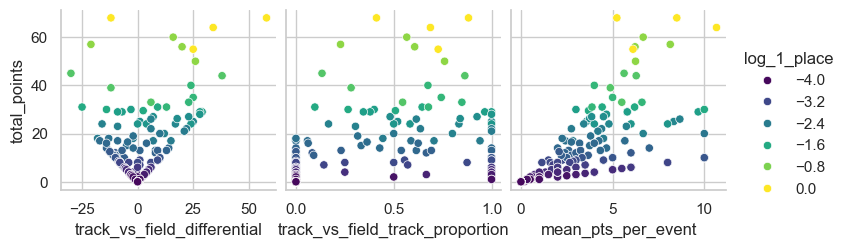

In [18]:
fi_events, fi_points = perform_basic_analysis(dfs_f_i, title="Women's Indoor")

In [19]:
fi_events

,total_points,place
n_events_participated,0.68,-0.66
n_events_10_pts_or_more,0.62,-0.61
n_events_8_pts_or_more,0.75,-0.73
n_events_6_pts_or_more,0.81,-0.79
n_events_5_pts_or_more,0.88,-0.86
n_events_4_pts_or_more,0.92,-0.90
n_events_3_pts_or_more,0.94,-0.92
n_events_2_pts_or_more,0.95,-0.94
n_events_1_pts_or_more,0.96,-0.94
n_events_sprints,0.42,-0.42


In [20]:
fi_points

,total_points,place
std_pts_per_event,0.80,-0.78
std_pts_sprints,0.36,-0.35
std_pts_hurdles,nan,nan
std_pts_mid_distance,0.29,-0.28
std_pts_distance,0.35,-0.34
std_pts_jumps,0.39,-0.38
std_pts_throws,0.13,-0.13
std_pts_track,0.65,-0.64
std_pts_field,0.47,-0.46
std_pts_disciplines,0.98,-0.96


### Men's Indoor Championships

In [21]:
dfs_m_i = add_metrics(dfs_m_i)

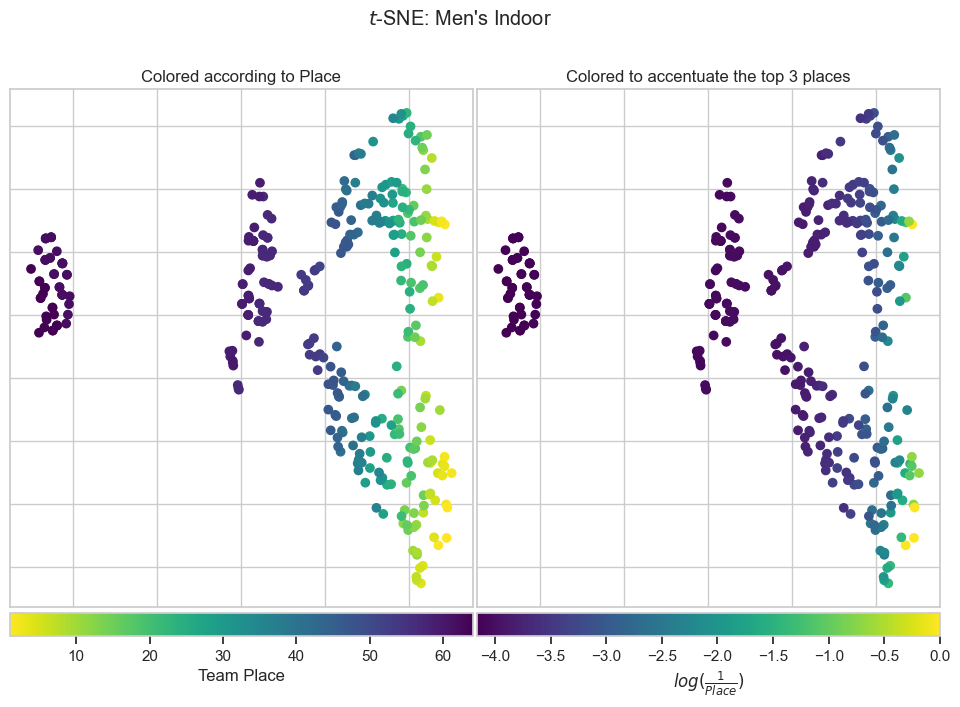

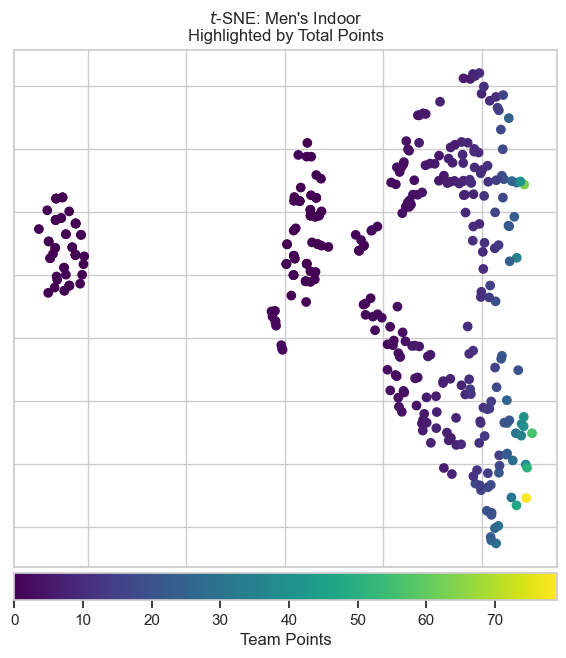

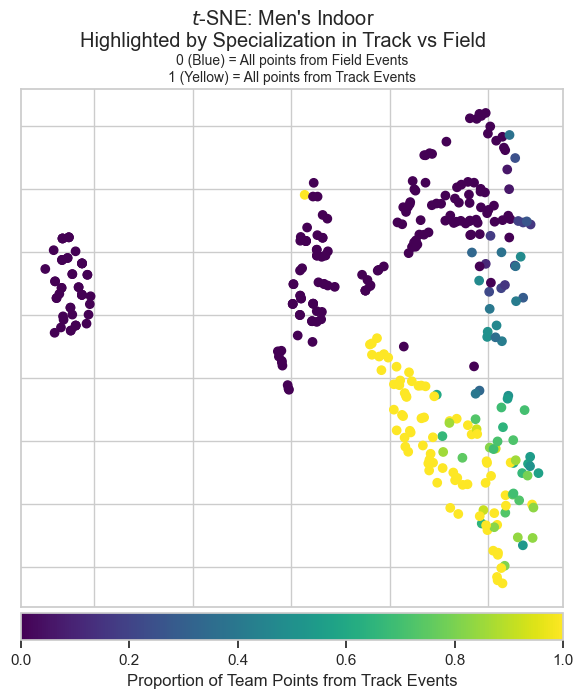

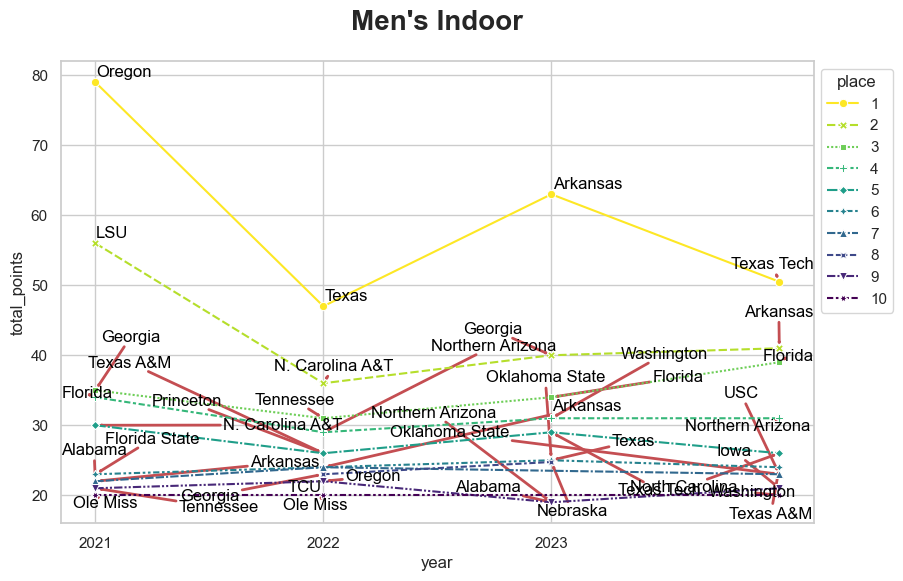

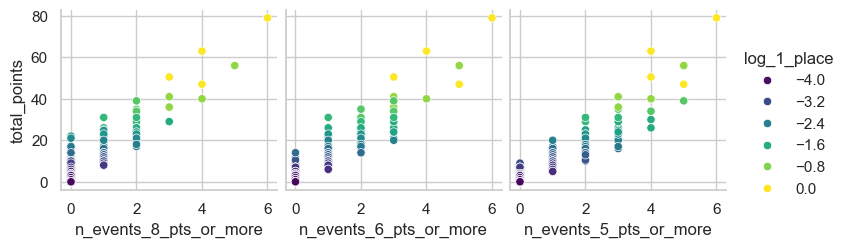

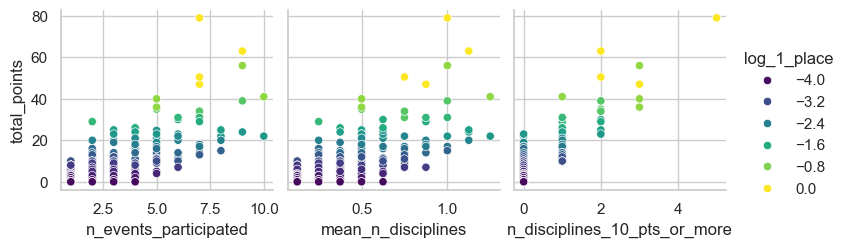

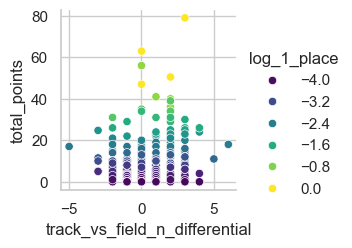

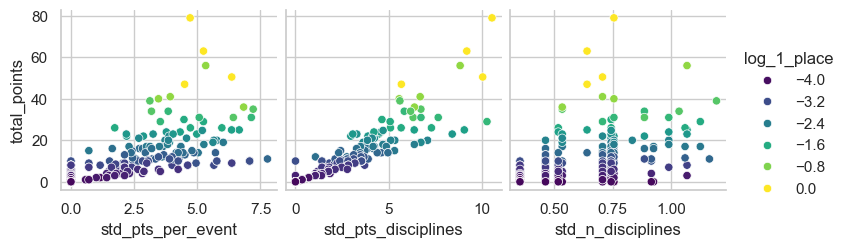

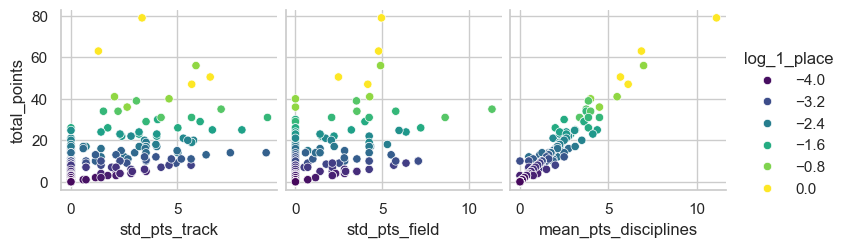

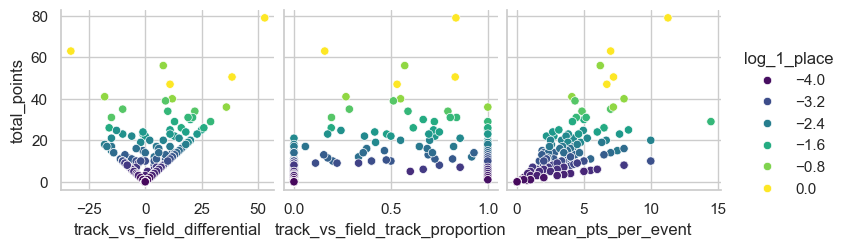

In [25]:
mi_events, mi_points = perform_basic_analysis(dfs_m_i, title="Men's Indoor")

In [26]:
mi_events

,total_points,place
n_events_participated,0.69,-0.67
n_events_10_pts_or_more,0.59,-0.58
n_events_8_pts_or_more,0.75,-0.73
n_events_6_pts_or_more,0.85,-0.83
n_events_5_pts_or_more,0.90,-0.89
n_events_4_pts_or_more,0.93,-0.92
n_events_3_pts_or_more,0.95,-0.93
n_events_2_pts_or_more,0.95,-0.93
n_events_1_pts_or_more,0.95,-0.92
n_events_sprints,0.32,-0.32


In [27]:
mi_points

,total_points,place
std_pts_per_event,0.82,-0.80
std_pts_sprints,0.27,-0.26
std_pts_hurdles,nan,nan
std_pts_mid_distance,0.34,-0.33
std_pts_distance,0.32,-0.32
std_pts_jumps,0.29,-0.28
std_pts_throws,0.19,-0.19
std_pts_track,0.66,-0.65
std_pts_field,0.50,-0.48
std_pts_disciplines,0.98,-0.95
